# Time Series Forecasting with GRU/LSTM

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras import Sequential, Input
from tensorflow.python.keras.layers import LSTM, Dropout, GRU, Dense
from tensorflow.python.keras.losses import mean_squared_error
from tensorflow.python.keras.optimizer_v2.gradient_descent import SGD

## Load data and see values

In [4]:
data = pd.read_csv("./GOOGL_2006-01-01_to_2018-01-01.csv", parse_dates=["Date"],index_col="Date")

In [5]:
print("data shape")
print(data.shape)

data shape
(3019, 6)


In [6]:
print("data")
print(data.head())

data
              Open    High     Low   Close    Volume   Name
Date                                                       
2006-01-03  211.47  218.05  209.32  217.83  13137450  GOOGL
2006-01-04  222.17  224.70  220.09  222.84  15292353  GOOGL
2006-01-05  223.22  226.00  220.97  225.85  10815661  GOOGL
2006-01-06  228.66  235.49  226.85  233.06  17759521  GOOGL
2006-01-09  233.44  236.94  230.70  233.68  12795837  GOOGL


In [7]:
print("Info\n")
data.info()

Info

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3019 non-null   float64
 1   High    3019 non-null   float64
 2   Low     3019 non-null   float64
 3   Close   3019 non-null   float64
 4   Volume  3019 non-null   int64  
 5   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 165.1+ KB


## Data


In [8]:
chunk = 60

In [9]:
sc = MinMaxScaler(feature_range=(0,1))
def prepare_data(dataset,features, train_size=0.9):
    train_length = round(len(dataset) * train_size)
    print("train length " + str(train_length))
    return dataset[features].iloc[:train_length], dataset[features].iloc[train_length:(len(dataset)-1)]

def plot_data(x, y):
    x["Close"].plot(figsize=(16,4),legend=True)
    y["Close"].plot(figsize=(16,4),legend=True)
    plt.legend(["Training","Testing"])
    plt.show()

def set_data_to_chunks(t, chunk_size=20):
    x = []
    y =[]
    for i in range(chunk_size,len(t)-1):
        x.append(t[i-chunk_size:i,0])
        y.append(t[i,0])
    return np.array(x),np.array(y)

train length 2717


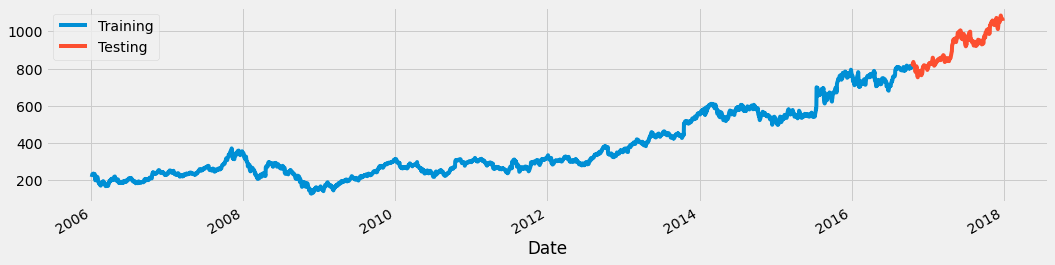

array([0.128465  , 0.1356982 , 0.14004389, 0.15045334, 0.15134846,
       0.15341303, 0.15477015, 0.14899515, 0.15088646, 0.15150728,
       0.1354672 , 0.12934569, 0.10262185, 0.12287769, 0.13411007,
       0.12686244, 0.127772  , 0.12720894, 0.12238681, 0.126617  ,
       0.1042966 , 0.10015304, 0.08968584, 0.09224128, 0.07982502,
       0.08066239, 0.07321264, 0.07599908, 0.0637705 , 0.06205244,
       0.06137387, 0.07877108, 0.08043139, 0.07887214, 0.07807808,
       0.08715927, 0.08668284, 0.09605278, 0.07599908, 0.07757277,
       0.08598984, 0.0872459 , 0.07995495, 0.07732733, 0.06968988,
       0.06182144, 0.05785112, 0.0575335 , 0.06772638, 0.06290425,
       0.05876068, 0.059497  , 0.06557519, 0.05959806, 0.05981462,
       0.06102737, 0.07829464, 0.08110996, 0.08653846, 0.09938785])

In [10]:
cz = 60
train, test = prepare_data(data,["Close"])
plot_data(train, test)

sc_train = sc.fit_transform(train)
X_train, y_train = set_data_to_chunks(sc_train,chunk_size=cz)
X_train[0]

In [11]:
# Reshape X_train
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1],1))


In [12]:
X_train.shape[1]

60

## Model Creation

In [13]:
lstm = Sequential()
lstm.add(LSTM(units=50, return_sequences=True, input_shape=(cz,1)))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=50, return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=50))
lstm.add(Dropout(0.1))
lstm.add(Dense(units=1))

lstm.compile(optimizer='rmsprop', loss=mean_squared_error)
lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [14]:
# Train model
lstm.fit(X_train, y_train, epochs=20, batch_size=30)

Epoch 1/20
89/89 [==============================] - 162s 2s/step - loss: 0.0216

In [17]:
sc_test = sc.fit_transform(test)
X_test, y_test = set_data_to_chunks(sc_test,chunk_size=60)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1],1))
lstmPred = lstm.predict(X_test)
lstmPred = sc.inverse_transform(lstmPred)

### Plot predictions

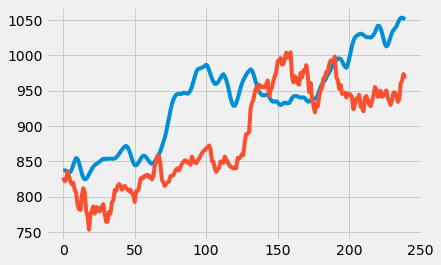

In [18]:
testvalues = test[:len(test)-61]
rang = range(len(testvalues))
plt.plot(rang,lstmPred)
plt.plot(rang,testvalues.values)
plt.show()

## Conclusion
Zoals je hierboven ziet is het niet super accuraat. Hij lijdt de goede kant op, maar aandelen blijven altijd
onvoorspelbaar. Hierdoor kan je ook niet super erg op deze waardes uitgaan maar het is een mooie test voor lstm.


## References
https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231